In [1]:
from keras.applications.vgg16 import VGG16

In [2]:
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
# 第一層param: 單一圖w(9 * 3) * n(64) + bias(64)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
from keras.datasets.cifar10 import load_data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = load_data()

In [4]:
print("訓練維度:", x_train.shape)
print("測試維度:", x_test.shape)

訓練維度: (50000, 32, 32, 3)
測試維度: (10000, 32, 32, 3)


In [8]:
transdict = {0:"飛機", 1:"汽車", 2:"鳥", 3:"貓", 4:"鹿",
             5:"狗", 6:"青蛙", 7:"馬", 8:"船", 9:"卡車"}


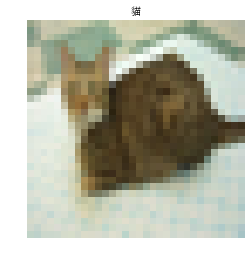

In [20]:
# 秀一下資料
# https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
font = matplotlib.font_manager.FontProperties(fname='NotoSerifCJKtc-Regular.otf')
c = random.randint(0, 49999)
plt.title(transdict[y_train[c][0]],fontproperties=font)
plt.axis("off")
plt.imshow(x_train[c])

In [23]:
# 預處理
# 圖片特徵(題目) 0~1, 如果要in MLP->攤平
x_train_shape = x_train / 255
x_test_shape = x_test / 255
# 答案處理 -> One-Hot Encoding
from keras.utils import np_utils
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)
print("答案:", y_train[0])
print("One-Hot:", y_train_cat[0])

答案: [6]
One-Hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [29]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
cnn = Sequential()
cnn.add(Conv2D(input_shape=(32, 32, 3),
               kernel_size=(3, 3),
               filters=32,
               activation="relu",
               padding="same"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(kernel_size=(3, 3),
               filters=64,
               activation="relu",
               padding="same"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(kernel_size=(3, 3),
               filters=128,
               activation="relu",
               padding="same"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units=256, activation="relu"))
cnn.add(Dense(units=10, activation="softmax"))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
__________

In [30]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
# epochs: 整份資料看幾次(10->60000 * 10 = 600000) -> 調整來避免過擬合
# batch: 看幾次一次梯度更新
# ?次:
# verbose: 打印log的詳細程度
history = cnn.fit(x_train_shape, 
                    y_train_cat, 
                    batch_size=200, 
                    epochs=10, 
                    validation_split=0.1, 
                    verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 45s 992us/step - loss: 1.5805 - acc: 0.4244 - val_loss: 1.2865 - val_acc: 0.5308
Epoch 2/10
45000/45000 [==============================] - 44s 983us/step - loss: 1.1838 - acc: 0.5812 - val_loss: 1.0848 - val_acc: 0.6196
Epoch 3/10
45000/45000 [==============================] - 44s 977us/step - loss: 1.0021 - acc: 0.6500 - val_loss: 0.9447 - val_acc: 0.6706
Epoch 4/10
45000/45000 [==============================] - 45s 992us/step - loss: 0.8834 - acc: 0.6914 - val_loss: 0.8799 - val_acc: 0.6968
Epoch 5/10
45000/45000 [==============================] - 44s 985us/step - loss: 0.7965 - acc: 0.7248 - val_loss: 0.8011 - val_acc: 0.7302
Epoch 6/10
45000/45000 [==============================] - 43s 966us/step - loss: 0.7252 - acc: 0.7477 - val_loss: 0.8335 - val_acc: 0.7154
Epoch 7/10
45000/45000 [==============================] - 43s 967us/step - loss: 0.6574 - acc: 0.7729 - val_loss: 0.7

In [33]:
# evaluate -> predict -> 算metrics
cnn.evaluate(x_test_shape, y_test_cat)

10000/10000 [==============================] - 4s 360us/step


[0.7893935303688049, 0.7406]

In [36]:
import pandas as pd
pre = cnn.predict_classes(x_test_shape)
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, pre))

,0,1,2,3,4,5,6,7,8,9
0,736,16,48,16,31,4,7,5,112,25
1,16,865,8,4,5,3,13,1,44,41
2,57,8,668,66,92,36,34,21,13,5
3,19,8,65,619,83,102,50,23,22,9
4,16,3,77,43,755,26,33,30,15,2
5,10,4,49,223,61,559,36,40,10,8
6,6,6,65,65,32,22,790,3,8,3
7,15,5,45,50,76,42,8,749,2,8
8,28,21,10,8,5,3,3,4,901,17
9,32,91,10,22,6,9,8,10,48,764


In [49]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]])

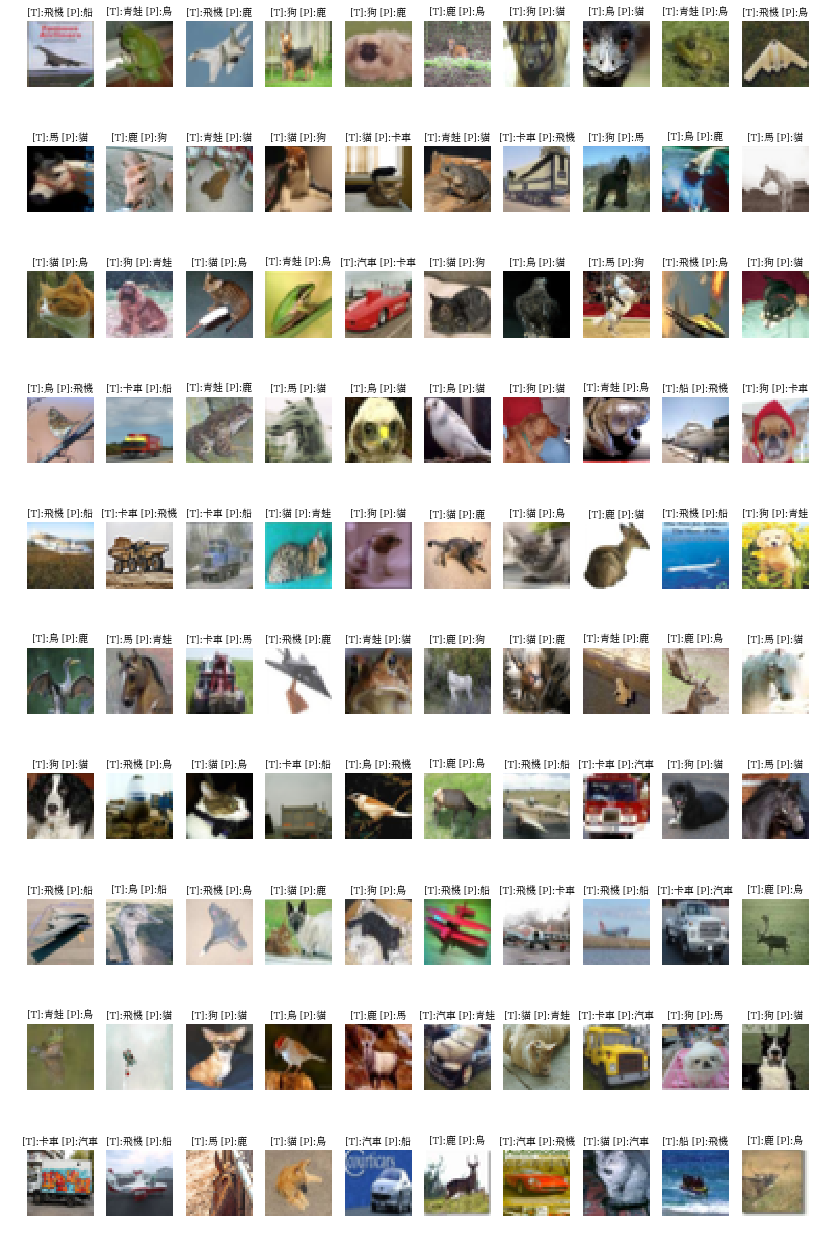

In [46]:
pre_false = []
ans_false = []
img_false = []

count = 0
for (index, p) in enumerate(pre):
    if not p == y_test[index][0]:
        pre_false.append(p)
        ans_false.append(y_test[index][0])
        img_false.append(x_test[index])
        count = count + 1
    if count == 100:
        break
        
width = 10
height = int(len(pre_false) / width) + 1
plt.figure(figsize=(14, 25))
for (index, img) in enumerate(img_false):
    plt.subplot(height, width, index + 1)
    # T原始答案　P預測答案
    t = "[T]:" + transdict[ans_false[index]] + " [P]:" + transdict[pre_false[index]]
    plt.title(t, fontproperties=font)
    plt.axis("off")
    plt.imshow(img)